In [1]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from wheelbehavior.wheelParser import *
from wheelbehavior.utils import *

In [3]:
import natsort
import numpy.ma as ma
import pylab as plt
import matplotlib.patheffects as path_effects
from scipy.optimize import curve_fit
from scipy.stats import sem
from datetime import datetime as dt
from os.path import join as pjoin

In [4]:
# color codes for different stimuli (areas)
area_colors = dict(AL_normal='tab:orange',
                   AL_opto='tab:blue',
                   PM_normal='tab:green',
                   PM_opto='tab:cyan',
                   grating_normal='tab:orange',
                   grating_opto='tab:blue')

contrast_colors = {0:'tab:red',
                   0.125:'tab:orange',
                   0.25:'tab:olive',
                   0.5:'tab:green',
                   1:'tab:blue'}

In [5]:
class WheelCurve:
    def __init__(self, name, rawdata):
        self.name = name
        self.rawdata = rawdata
        self.bias = []
        self.binomial = []

        self.contrast = np.unique(self.rawdata['contrast'])
        neg_contrast = [-1 * c for c in self.contrast]
        self.contrast_x = np.unique(np.hstack((neg_contrast[::-1], self.contrast)))

        self.get_distribution()
        self.calculate_bias()
        self.fit_curve()

    def get_distribution(self):
        '''
        Returns the distribution of conrasts in a curve
        '''
        curve_dist = dict(left=[],
                          right=[])
        left = self.rawdata[np.sign(self.rawdata['stim_side']) == -1]
        right = self.rawdata[np.sign(self.rawdata['stim_side']) == 1]

        for c in self.contrast:
            curve_dist['left'].append(len(left[left['contrast'] == c]))
            curve_dist['right'].append(len(right[right['contrast'] == c]))

        self.curve_dist = curve_dist

    def calculate_bias(self):
        '''
        Calculates the biases for different contrats values with %95 binomial confidence
        '''
        zero_c = 0
        for i, c in enumerate(self.contrast):
            contrast_left_df = self.rawdata[
                (self.rawdata['contrast'] == c) & (np.sign(self.rawdata['stim_side']) == -1)]
            # stim on left
            if len(contrast_left_df):
                incorrectly_right = contrast_left_df[contrast_left_df['answer'] == -1]
                percent_right_left = len(incorrectly_right) / len(contrast_left_df)
                bino_right_left = 1.96 * np.sqrt(
                    (percent_right_left * (1 - percent_right_left)) / len(contrast_left_df))  # 95% binomial
            else:
                incorrectly_right = []
                percent_right_left = 0
                bino_right_left = 0
            contrast_right_df = self.rawdata[(self.rawdata['contrast'] == c) & (np.sign(self.rawdata['stim_side']) == 1)]
            # stim on right
            if len(contrast_right_df):
                correctly_right = contrast_right_df[contrast_right_df['answer'] == 1]
                percent_right_right = len(correctly_right) / len(contrast_right_df)
                bino_right_right = 1.96 * np.sqrt(
                    (percent_right_right * (1 - percent_right_right)) / len(contrast_right_df))  # 95% binomial
            else:
                correctly_right = []
                percent_right_right = 0
                bino_right_right = 0

            if c == 0:
                contrast_zero = self.rawdata[self.rawdata['contrast'] == c]
                percent_zero_right = (len(incorrectly_right) + len(correctly_right)) / len(contrast_zero)
                bino_zero_right = 1.96 * np.sqrt(
                    (percent_zero_right * (1 - percent_zero_right)) / len(contrast_zero))  # 95% binomial

                self.bias.append(percent_zero_right)
                self.binomial.append(bino_zero_right)
            else:
                self.bias.insert(0, percent_right_left)
                self.binomial.insert(0, bino_right_left)

                self.bias.append(percent_right_right)
                self.binomial.append(bino_right_right)

    def fit_curve(self, resolution=100):
        '''
        L = max value of sigmoid
        k = logistic growth rate aka steepness
        b = y-offset
        '''
        sigmoid = lambda x, L, k, b: L / (1.0 + np.exp(-k * (x))) + b

        p0 = [np.max(self.bias), 0, np.min(self.bias)]  # initial guesses for parameters
        try:
            popt, pcov = curve_fit(sigmoid,
                                   self.contrast_x,
                                   self.bias,
                                   p0,
                                   method='lm')
            self.contrast_x_fitted = np.linspace(self.contrast_x.min(), self.contrast_x.max(), resolution).reshape(-1, 1)
            self.bias_fitted = np.asarray(sigmoid(self.contrast_x_fitted, *popt)).reshape(-1, 1)
        
        except:
            # If can't fit just put out the same data as original
            print('Error fitting the data')
            self.contrast_x_fitted = self.contrast_x
            self.bias_fitted = self.bias

In [6]:
class WheelTrajectory:
    def __init__(self, name, rawdata):
        self.name = name
        self.rawdata = rawdata
        self.trajectories = {}
        self.averages = {}
        self.sems = {}
        if np.unique(self.rawdata['opto']).tolist() == [0]:
            self.optogenetic = False
        else:
            self.optogenetic = True
        # apply len to wheel column
        self.rawdata['wheel_len'] = self.rawdata['wheel'].apply(lambda x: len(x))

        self.sync()
        self.get_trajectories()

    def sync(self):
        # sync timeframes to start from 0
        self.rawdata['wheel'] = self.rawdata['wheel'].apply(
            lambda x: np.asarray([np.add(x[:, 0], -1 * x[0, 0]), x[:, 1]]).T)
        # sync wheel positions
        self.rawdata['wheel'] = self.rawdata['wheel'].apply(
            lambda x: np.asarray([x[:, 0], np.add(x[:, 1], -1 * x[0, 1])]).T)

    def get_trajectories(self):
        contrast_list = np.unique(self.rawdata['contrast'])

        for c in contrast_list:
            self.trajectories[c] = {}
            self.averages[c] = {}
            self.sems[c] = {}
            if self.optogenetic:
                opto_loop = [0,1]
            else:
                opto_loop = [0]
            for opto in opto_loop:
                c_slice = self.rawdata[(self.rawdata['contrast'] == c) & (self.rawdata['opto'] == opto)]

                c_slice.reset_index(drop=True, inplace=True)
                if len(c_slice):
                    imax = c_slice['wheel_len'].idxmax()
                    max_wheel = c_slice['wheel'].iloc[imax]

                    # create the template masked array and mask
                    # rows = wheel data points
                    # columns = [time, wheel]
                    # depth = each trial that satisfies opto=o, contrast=c, stim_side=s, answer=answered
                    tmp = np.zeros((max_wheel.shape[0], max_wheel.shape[1], len(c_slice)))
                    mask = np.ones_like(tmp)

                    for i, row in c_slice.iterrows():
                        wheel_len = row['wheel_len']
                        wheel_vals = row['wheel']
                        tmp[0:wheel_len, :, i] = wheel_vals
                        mask[0:wheel_len, :, i] = 0

                    # add it to the trajectory matrix
                    trj_array = ma.array(data=tmp, mask=mask)
                    
                    #get the mean 
                    avg = np.average(trj_array[:, 1, :], axis=1).data.reshape(-1, 1)
                    avg_t = max_wheel[:, 0].reshape(-1, 1)
                    avg_array = np.hstack((avg_t, avg))
                    
                    #get the s.e.m
                    sems_array = sem(trj_array[:,1,:], axis=1).reshape(-1,1)
                    
                else:
                    trj_array = None
                    avg_array = None
                    sems_array = None

                if opto == 1:
                    self.trajectories[c]['opto'] = trj_array
                    self.averages[c]['opto'] = avg_array
                    self.sems[c]['opto'] = sems_array
                else:
                    self.trajectories[c]['nonopto'] = trj_array
                    self.averages[c]['nonopto'] = avg_array
                    self.sems[c]['nonopto'] = sems_array

    # CURRENTLY ONLY FOR CORRECT AND INCORRECT ANSWERS
    def get_confidence(self):
        legit_answer_df = self.session_data[self.session_data['answer'] != 0]
        confidence_dict = {}
        for i, row in legit_answer_df.iterrows():
            nturns = get_turning_points(row['stim_pos'])
            confidence_index = 1 - (nturns / len(row['stim_pos']))
            confidence_dict[row['trial_no']] = [row['contrast'], confidence_index]

        return confidence_dict

In [60]:
class WheelSession:
    def __init__(self, sessiondir,load_data=True, autoplot=True):
        self.sessiondir = sessiondir
        self.experimentname = self.sessiondir.split('/')[-1]
        self.animalid = self.sessiondir.split('_')[1]
        
        self.parser = WheelParser(self.sessiondir,load_data=load_data)
        self.session_data = self.parser.session_data

        if self.session_data is None:
            self.session_summary = None
            self.metadata = None
        else:
            self.prefpath = self.parser.prefpath
            self.comments = self.parser.comments
            self.level = self.parser.level
            self.get_metadata()
            self.session_summary = self.get_session_summary()
            if autoplot:
                self.init_plotter(savefig=True)
                self.plot_all()
            

        

    def get_metadata(self):
        # get metadata
        self.date = dt.strftime(dt.strptime(self.sessiondir.split('/')[-1].split('_')[0], '%y%m%d').date(), '%d %b %y')
        runname = [x.split(':')[1] for x in self.comments if 'Filename' in x][0].split('.')[0].strip(' ')
        if 'opto' in runname:
            opto = True
        else:
            opto = False

        starttime = self.comments[2].split('-')[-1].strip(' ')
        # runtime = self.data['vstim'].iloc[-1]['presentTime'] / 60000  # minutes

        p = parsePref(self.prefpath)
        self.rig = p['tmpFolder'].split('\\')[-1]

        self.metadata = dict(date=self.date,
                             starttime=starttime,
                             rig=self.rig,
                             runname=runname,
                             opto=opto)

    def get_session_summary(self):
        curves = {}
        trajectories = {}
        data = {}

        # convert the timescale to mins and make the bins
        # trial_end_mins = self.session_data['trial_end'].values / 60000
        # min_bins = np.arange(0, trial_end_mins[-1], 1)
        # trial_cnt, _ = np.histogram(trial_end_mins, bins=min_bins)

        # attention = np.hstack((min_bins.reshape(-1, 1)[1:], trial_cnt.reshape(-1, 1)))
        
        noncorr_data = self.session_data[self.session_data['correction'] == 0]
        
        #left
        left_data = noncorr_data[noncorr_data['stim_side'] <= 0]
        left_profile = [-len(left_data[left_data['answer']==1]), -len(left_data[left_data['answer']==-1]),-len(left_data[left_data['answer']==0])]
        #right 
        right_data = noncorr_data[noncorr_data['stim_side'] >= 0]
        right_profile = [len(right_data[right_data['answer']==1]), len(right_data[right_data['answer']==-1]),len(right_data[right_data['answer']==0])]

        answered_data = noncorr_data[noncorr_data['answer']!=0]
        
        if not answered_data.empty:
            answered_correct_pct = 100 * len(answered_data[answered_data['answer']==1])/len(answered_data)
            all_correct_pct = 100 * len(answered_data[answered_data['answer']==1])/len(noncorr_data)
            total_latency = np.sum(answered_data['response_latency'])

            freq = np.unique(answered_data['spatial_freq'])
            for f in freq:
                if f == 0.4:
                    key = 'PM'
                elif f == 0.05:
                    key = 'AL'
                else:
                    key = 'grating'

                freq_data = answered_data[answered_data['spatial_freq'] == f]

                # psychometric curves are seperated by opto and non-opto
                curve_data = {}
                if self.metadata['opto']:
                    curve_data['opto'] = freq_data[freq_data['opto'] == 1]
                    curve_data['normal'] = freq_data[freq_data['opto'] == 0]
                else:
                    curve_data['normal'] = freq_data

                for k in curve_data.keys():
                    name = '{0}_{1}'.format(key, k)
                    curves[name] = WheelCurve(name=name, rawdata=curve_data[k])

                # wheel trajectories are seperated by stimulus side
                sides = np.unique(freq_data['stim_side'])
                for s in sides:
                    if s < 0:
                        sname = 'left'
                    elif s > 0:
                        sname = 'right'
                    name = '{0}_{1}'.format(key, sname)
                    trajectory_data = freq_data[freq_data['stim_side'] == s]
                    trajectories[name] = WheelTrajectory(name=name, rawdata=trajectory_data)
            
            return dict(level = self.level,
                        rig = self.rig,
                        all_trials = len(self.session_data),
                        novel_trials = len(noncorr_data),
                        answered_trials = len(answered_data),
                        answered_correct = answered_correct_pct,
                        all_correct = all_correct_pct,
                        left_profile = left_profile,
                        right_profile = right_profile,
                        contrast = np.unique(self.session_data['contrast']),
                        latency = total_latency / len(answered_data),
                        curves = curves,
                        trajectories = trajectories)
        
        else:
            return None
        
        
    def append_plot_data(self,df):
        df['marker'] = df['correction'].apply(lambda x: '+' if x else 'o')
        sign = np.sign(df['stim_side'])
        df['y_offset'] = sign*df['correction'].apply(lambda x: 1+x/5)
        df['color'] = 'k'
        df.loc[df['answer']==1,'color']='g'
        df.loc[df['answer']==-1,'color']='r'     
        return df
            
    def init_plotter(self, savefig=False, plot_params=None):
        if plot_params is None:
            plot_params = dict(fig_size=(15, 15),
                               font_size=20,
                               title_size=23,
                               line_width=3,
                               bar_width=0.15,
                               marker_size=10)
        self.savefig = savefig
        self.plot_params = plot_params

    def plot(self, plotkey='psychometric',size_override=None,ax=None):
        if size_override is None:
            fig = plt.figure(figsize=self.plot_params['fig_size'])
        else:
            fig = plt.figure(figsize=size_override)
        fig.suptitle('{0} {1}'.format(self.animalid, self.date), fontsize=self.plot_params['title_size'])
        if plotkey is 'psychometric':
            # psychometric graph
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            for k in self.session_summary['curves'].keys():
                tmp_curve = self.session_summary['curves'][k]

                ax.plot(100 * tmp_curve.contrast_x_fitted, tmp_curve.bias_fitted,
                        c=area_colors[k],
                        linewidth=8)

                ax.errorbar(100 * tmp_curve.contrast_x, tmp_curve.bias, tmp_curve.binomial,
                            marker='o',
                            c=area_colors[k],
                            linewidth=0,
                            markersize=self.plot_params['marker_size'],
                            elinewidth=self.plot_params['line_width'],
                            capsize=5,
                            label='{0}'.format(k))
            #midlines
            ax.plot([0, 0], [-0.1, 1.1], 'k', linestyle=':', linewidth=2)
            ax.plot([-105, 105], [0.5, 0.5], 'k', linestyle=':', linewidth=2)

            ax.set_xlim([-105, 105])
            ax.set_ylim([-0.1, 1.1])
            ax.set_title('Psychometric Curve', fontsize=self.plot_params['title_size'])
            ax.set_xlabel('Contrast Value', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('Prob. Choosing Right(%)', fontsize=self.plot_params['font_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.legend(loc=[0.07, 0.75], fontsize=12, borderpad=0.1, labelspacing=0.4, prop={'size': 14})

        elif plotkey is 'performance':
            # performance plot
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            
            plot_data = self.append_plot_data(self.session_data)
            
            #legit trials
            legit_data = plot_data[plot_data['correction']==0]
            ml = np.unique(legit_data['marker'])[0]
            ax.scatter(legit_data['trial_no'],legit_data['y_offset'],
                        c=legit_data['color'], 
                        marker=ml)
            #corrections
            corr_data = plot_data[plot_data['correction']!=0]
            mc = np.unique(corr_data['marker'])[0]
            ax.scatter(corr_data['trial_no'],corr_data['y_offset'],
                        c=corr_data['color'], 
                        marker=mc)
            #midline
            ax.plot([-1, plot_data['trial_no'].iloc[-1]+1], [0, 0], 'k', linestyle=':', linewidth=2)
            
            ax.set_ylim([-3, 3])
            ax.set_xlabel('Trial No', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('Left <==> Right', fontsize=self.plot_params['font_size'])
            # ax.legend(loc='upper left',fontsize=self.plot_params['font_size'])
            ax.set_title('Performance PC={0:.2f}%({1:.2f}%)'.format(self.session_summary['answered_correct'],self.session_summary['all_correct']), 
                         fontsize=self.plot_params['title_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])
            ax.yaxis.set_major_locator(plt.NullLocator())
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

        elif plotkey is 'trajectory':
            # wheel trajectories
            nrow = np.ceil(len(self.session_summary['trajectories'].keys()))
            for i, k in enumerate(self.session_summary['trajectories'].keys()):
                ax = fig.add_subplot(nrow, 2, i + 1)
                # side
                side_traj = self.session_summary['trajectories'][k]
                
                # loops all contrasts
                legends=[]
                for c in side_traj.trajectories.keys():
                    contrast_trj = side_traj.trajectories[c]
                    if contrast_trj['nonopto'] is not None:
                        avg_x = side_traj.averages[c]['nonopto'][:, 0]
                        avg_y = side_traj.averages[c]['nonopto'][:, 1]
                        semy = side_traj.sems[c]['nonopto'][:,0]
                        # individual trajectories
#                         for t in range(contrast_trj['nonopto'].shape[2]):
#                             # nonopto
#                             ax.plot(contrast_trj['nonopto'][:, 0, t], contrast_trj['nonopto'][:, 1, t],
#                                     linewidth=3,
#                                     color=contrast_colors[c],
#                                     alpha=0.3)
                        # nonopto avg
                        nonopto_line, = ax.plot(avg_x, avg_y,
                                linewidth=self.plot_params['line_width'],
                                color=contrast_colors[c],
                                label='{0}%'.format(100*c))
        
                        ax.fill_between(avg_x,avg_y-semy,avg_y+semy,
                                        color=contrast_colors[c],
                                        alpha=0.3)
                        legends.append(nonopto_line)
                    if side_traj.optogenetic:
                        if contrast_trj['opto'] is not None:
                            avg_x = side_traj.averages[c]['opto'][:, 0]
                            avg_y = side_traj.averages[c]['opto'][:, 1]
                            semy = side_traj.sems[c]['opto'][:,0]
                            # individual trajectories
    #                             for t in range(contrast_trj['opto'].shape[2]):
    #                                 # opto
    #                                 ax.plot(contrast_trj['opto'][:, 0, t], contrast_trj['opto'][:, 1, t],
    #                                         linewidth=2,
    #                                         color=contrast_colors[c],
    #                                         path_effects=[path_effects.Stroke(linewidth=2.5, foreground="b", alpha=0.3),
    #                                                       path_effects.Normal()],
    #                                         alpha=0.3)
                            # opto avg
                            opto_line, = ax.plot(avg_x, avg_y,
                                    linewidth=self.plot_params['line_width'],
                                    color=contrast_colors[c],
                                    path_effects=[
                                        path_effects.Stroke(linewidth=self.plot_params['line_width'] + 2, foreground="b"),
                                        path_effects.Normal()],
                                    label='{0}% Opto'.format(100*c))

                            ax.fill_between(avg_x,avg_y-semy,avg_y+semy,
                                        color=contrast_colors[c],
                                        alpha=0.3)
                            legends.append(opto_line)
        
                # closed loop start line
                ax.plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0,0],'k',linewidth=3)
                ax.plot([1000, 1000], [-300, 300], 'k', linestyle=':', linewidth=2)
                ax.set_ylim([-300, 300])
                ax.set_xlabel('Time (ms)', fontsize=self.plot_params['font_size'])
                ax.set_ylabel('Wheel Position', fontsize=self.plot_params['font_size'])
                ax.set_title(k, fontsize=self.plot_params['title_size'])
                ax.tick_params(labelsize=self.plot_params['font_size'])
                ax.legend(handles=legends)

        elif plotkey is 'attention':
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)

            attn = self.session_summary['attention']
            ax.plot(attn[:, 0], attn[:, 1],
                    linewidth=self.plot_params['line_width'])

            ax.set_xlabel('Minutes', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('Trials per min', fontsize=self.plot_params['font_size'])
            ax.set_title('Attention', fontsize=self.plot_params['title_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])

        elif plotkey is 'confidence':
            pass
        elif plotkey is 'correction':
            pass
        else:
            print('''Plotting {0} is not implemented yet, try:
            - psychometric
            - performance
            - trajectory
            - attention
            - confidence
            - correction
                  '''.format(plotkey))

        if self.savefig:
            analysis_path = 'J:/data/analysis'
            saveloc = pjoin(analysis_path,self.experimentname).replace("\\","/")

            experiments = os.listdir(analysis_path)

            #first analysis
            if self.experimentname not in experiments:
                os.makedirs(pjoin(saveloc,'figures'))

            #adding figures subdirectory to an existing experiment analysis directory
            if 'figures' not in os.listdir(saveloc):
                saveloc = pjoin(saveloc,'figures')
                os.mkdir(saveloc)
            else:
                saveloc = pjoin(saveloc,'figures')

            savename = '{0}_{1}_{2}.pdf'.format(self.experimentname.split('_')[0], self.animalid,plotkey)
            savepath = pjoin(saveloc, savename)
            fig.savefig(savepath)
            display('{0} plot saved in {1}'.format(plotkey,saveloc))
        return ax

    def plot_all(self):
        override=None
        plotkeys =  ['psychometric','performance','trajectory']
        self.figures = {}
        for key in plotkeys:
            display('Plotting {0}...'.format(key))
            if key is 'performance':
                override = (15,8)
            f = self.plot(key,size_override=override)
            self.figures[key]=f

In [61]:
import time

start = time.time()
w = WheelSession('200605_KC028_wheel_KC',autoplot=False)
end = time.time()
print(end - start)

The number of screen pulses 974 does not match the visual stimulation indicatorFlag:74429 log.
[20-06-07 22:44:11] - Loading from J:/data/analysis/200605_KC028_wheel_KC
[20-06-07 22:44:11] - Done!
1.55008864402771


H:\programs\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
H:\programs\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
H:\programs\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

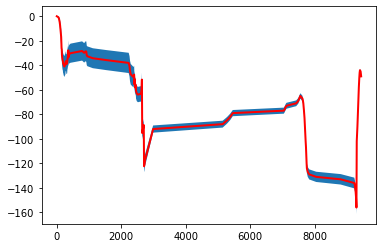

In [27]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
x=w.session_summary['trajectories']['AL_left'].averages[1]['nonopto'][:,0]
y=w.session_summary['trajectories']['AL_left'].averages[1]['nonopto'][:,1]
s=w.session_summary['trajectories']['AL_left'].sems[1]['nonopto'][:,0]
ax.plot(x,y,'r',linewidth=2)
ax.fill_between(x,y-s,y+s)

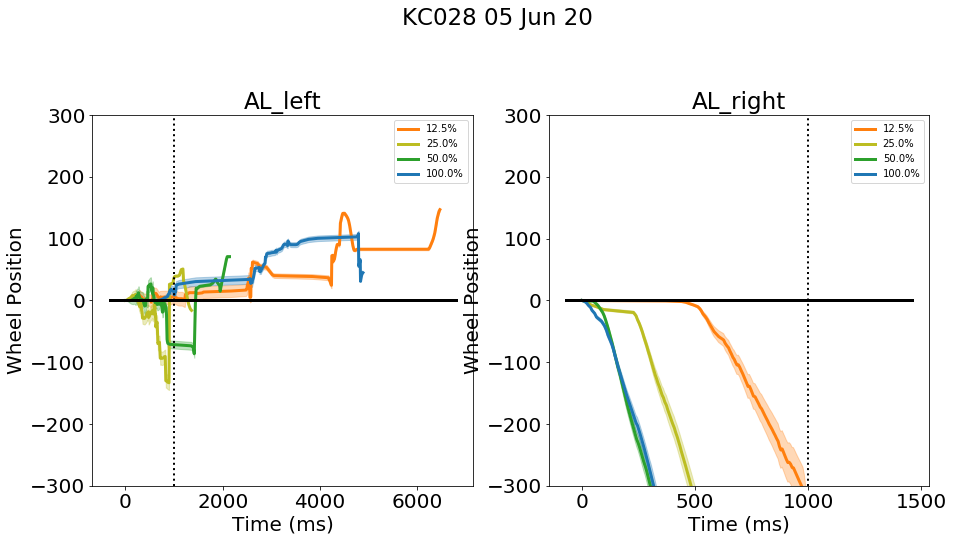

In [62]:
w.init_plotter()
f=w.plot('trajectory')

In [ ]:
class WheelBehavior():
    def __init__(self, animalid, dateinterval=None, criteria=None, autostart=False):
        self.animalid = animalid
        self.presentationfolder = 'J:/data/presentation'
        self.analysisfolder = 'J:/data/analysis'
        self.dateinterval = dateinterval
        self.prep_session_list()
        self.criteria = criteria
        if autostart:
            self.compile_data()
        

    def prep_session_list(self):
        # dateinterval is a list of two date strings e.g. ['200127','200131']
        session_list = [sesh for sesh in os.listdir(self.presentationfolder) if self.animalid in sesh]
        session_list = natsort.natsorted(session_list, reverse=False)
        #get only wheel sessions
        session_list = [sesh for sesh in session_list if 'wheel' in sesh]
        date_list = [dt.strptime(x.split('_')[0], '%y%m%d') for x in session_list]

        if type(self.dateinterval) is not list:
            self.dateinterval = [self.dateinterval]
            # add end date as today
            self.dateinterval.append(dt.today().strftime('%y%m%d'))
        if len(self.dateinterval) == 2:
            startdate = dt.strptime(self.dateinterval[0], '%y%m%d')
            enddate = dt.strptime(self.dateinterval[1], '%y%m%d')
            temp = np.asarray(
                [[session_list[i], date] for i, date in enumerate(date_list) if startdate <= date <= enddate])
        else:
            print('Date interval wrong!')

        self.session_list = temp
        self.last_session = pjoin(self.analysisfolder,self.session_list[-1,0]).replace("\\","/")

    # for now only thresholds bigger values
    def implement_criteria(self, rowtoappend):

        # filter data according to given criteria
        if self.criteria is None:
            print('No criteria given, including all {0} sessions'.format(len(self.session_list)))
            return 1
        else:
            satisfied = []
            for k in self.criteria.keys():
                if k not in rowtoappend.keys():
                    print('Criteria {0} not found in data, skipping'.format(k))
                    continue
                else:
                    if rowtoappend[k] >= self.criteria[k]:
                        satisfied.append(1)
                    else:
                        print('{0} not satisfied: {1} < {2}'.format(k, rowtoappend[k], self.criteria[k]))
                        satisfied.append(0)
            if 0 in satisfied:
                return 0
            else:
                return 1

    def compile_data(self,load_behavior=True,load_sessions=True):
        # no point in reading saved behavior data if reanalyzing session data
        if not load_sessions:
            load_behavior=False

        behavior_data = pd.DataFrame()
        missing_sessions = self.session_list
        if load_behavior:
            for i, sesh in enumerate(self.session_list[::-1]):
                #check if behavior data exists in one of the session directories inside the analysis directory
                datapath = pjoin(self.analysisfolder,sesh[0],'trainingData.pkl').replace("\\","/")
                if os.path.exists(datapath):
                    print('Found data in {0}, loading'.format(datapath))
                    behavior_data = pd.read_pickle(datapath)
                    if i:
                        missing_sessions = missing_sessions[-i:,:]
                        print('Adding {0} missing sessions to last analysis data'.format(len(missing_sessions)))
                        print('Deleting the old data in {0}'.format(datapath))
                        os.remove(datapath)
                    else:
                        missing_sessions = []
                    break
        for i,sesh in enumerate(missing_sessions):
            # gets the session summary from the analysis directory
            self.current_sesh = sesh
            temp_session = WheelSession(sesh[0],load_sessions)
            temp_summary = temp_session.session_summary
            if temp_summary is not None:
                session_row = temp_summary
                session_row['session_no'] = i + 1
                session_row['session_date'] = missing_sessions[i,1]

                # append if satisfies criteria
                if self.implement_criteria(session_row):
                    behavior_data = behavior_data.append(session_row, ignore_index=True)
                else:
                    continue
            else:
                print('No data for this session, skipping...')
                continue
        
        # Failsafe date sorting for non-analyzed all trials and empty sessions(?)
        behavior_data = behavior_data.sort_values('session_date', ascending=True)
        behavior_data.dropna(inplace=True)
        behavior_data.reset_index(inplace=True,drop=True)

        self.behavior_data = behavior_data
        
        # save behavior data to the last session analysis folder
        savepath = pjoin(self.analysisfolder,self.last_session,'trainingData.pkl').replace("\\","/")
        self.behavior_data.to_pickle(savepath)
        print('Behavior data saved in {0}'.format(self.last_session))
        return self.behavior_data
        
    # TODO: LOOK INTO THIS WITH MASKED ARRAYS
    def extract_bias_stats(self):
        bias_mean = {}
        bias_stderr = {}
        behavior_bias = {}
        bd = copy.deepcopy(self.behavior_data['bias'])
        for bias in bd:
            for k in bias.keys():
                b = bias[k].applymap(lambda y: [y])
                if k not in behavior_bias.keys():
                    behavior_bias[k] = b
                else:
                    for i in behavior_bias[k].columns:
                        if i not in b.columns:
                            b.insert(0, i, [[0], [0]])
                    n = behavior_bias[k].apply(lambda x: x + b[x.name])
                    behavior_bias[k] = n

        # combine the zeros

        # the mean and stderr and flatten
        for area in behavior_bias.keys():
            temp_mean = behavior_bias[area].applymap(np.mean)
            temp_stderr = behavior_bias[area].applymap(lambda x: np.std(x) / np.sqrt(len(x)))
            bias_mean[area] = pd.concat([temp_mean.iloc[0][::-1], temp_mean.iloc[1]])
            bias_stderr[area] = pd.concat([temp_stderr.iloc[0][::-1], temp_stderr.iloc[1]])

        # make the contrast axis
        contrast_axis = []
        for c in temp_mean.columns:
            contrast_axis.append(float(c) * 100)
            #             if float(c) != 0:
            contrast_axis.append(-1 * float(c) * 100)
        contrast_axis = np.sort(contrast_axis)

        return contrast_axis, bias_mean, bias_stderr

    def init_plotter(self,plot_params=None,savefig=False):
        if plot_params is None:
            plot_params = dict(fig_size=(15, 15),
                               font_size=20,
                               title_size=23,
                               line_width=8,
                               bar_width=1,
                               marker_size=10,
                               edge_width=2)
        self.plot_params = plot_params
        self.savefig = savefig
        
    def plot(self,plotkey='performance',size_override=None,savefig=None,ax=None):
        if size_override is None:
            fig = plt.figure(figsize=self.plot_params['fig_size'])
        else:
            fig = plt.figure(figsize=size_override)
            
        if savefig is None:
            savefig = self.savefig
        
        if plotkey is 'performance':
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            bd = self.behavior_data
            session_dates = bd['session_date']
            str_session_dates = [date.strftime('%d.%m.%y') for date in session_dates]

            left=np.array([bd['left_profile']])[0]
            right = np.array([bd['right_profile']])[0]

            bd['edge'] = 'white'
            bd.loc[bd['level']=='level2','edge']='orange'
            bd.loc[bd['level']=='level3','edge']='blue'  

            #LEFT
            #correct
            ax.bar(str_session_dates, left[:,0], 
                    width=self.plot_params['bar_width'],
                    color='darkgreen',
                    edgecolor=bd['edge'],
                    linewidth=self.plot_params['edge_width'])
            #incorrect
            ax.bar(str_session_dates, left[:,1], 
                    width=self.plot_params['bar_width'],
                    bottom=left[:,0],
                    color='maroon',
                    edgecolor=bd['edge'],
                    linewidth=self.plot_params['edge_width'])
            #non answer
            ans_hl = np.add(left[:,0], left[:,1]).tolist()
            ax.bar(str_session_dates, left[:,2], 
                    width=self.plot_params['bar_width'],
                    bottom=ans_hl,
                    color='k',
                    edgecolor=bd['edge'],
                    linewidth=self.plot_params['edge_width']) 

            #RIGHT
            #correct
            ax.bar(str_session_dates, right[:,0], 
                    width=self.plot_params['bar_width'],
                    color='darkgreen',
                    edgecolor=bd['edge'],
                    linewidth=self.plot_params['edge_width'])
            #incorrect
            ax.bar(str_session_dates, right[:,1], 
                    width=self.plot_params['bar_width'],
                    bottom=right[:,0],
                    color='maroon',
                    edgecolor=bd['edge'],
                    linewidth=self.plot_params['edge_width'])
            #non answer
            ans_hr = np.add(right[:,0], right[:,1]).tolist()
            ax.bar(str_session_dates, right[:,2], 
                    width=self.plot_params['bar_width'],
                    bottom=ans_hr,
                    color='k',
                    edgecolor=bd['edge'],
                    linewidth=self.plot_params['edge_width']) 

            for i,r in bd.iterrows():
                if len(r['rig'])==2:
                    y_offset = ans_hr[i]+right[i,2]+8
                    ax.text(str_session_dates[i], y_offset, r['rig'], fontsize=15)

            #midline
            ax.set_ylim([ax.get_ylim()[0]-15, ax.get_ylim()[1]+15])
            ax.plot(ax.get_xlim(),[0,0],'white',linewidth=2)
            ax.set_xlabel('Session Dates', fontsize=self.plot_params['font_size'])
            ax.tick_params(axis='x', rotation=90)
            ax.set_ylabel('Response Distribution(L<=>R)', fontsize=self.plot_params['font_size'])
            ax.set_title('{0} Performance'.format(self.animalid), fontsize=self.plot_params['font_size'])
            ax.tick_params(axis='both', size=self.plot_params['font_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])
            ax.grid(b=True,axis='y')
            ax.grid(b=True,axis='x',linewidth=0.5)
            ax.set_axisbelow(b=True)
            
        elif plotkey is 'psychometric':
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            pass
        else:
            pass 
        
        if savefig:
            # check 
            save_name = 'trainingSummary.pdf'
            
            savepath = pjoin(self.last_session,save_name).replace("\\","/")
            print('{0} graph saved in {1}'.format(plotkey,savepath))
            
            fig.savefig(savepath, bbox_inches='tight')
        return ax

        # performance with error bars for AL and PM
#         ax2 = axes[1]
#         contrast_axis, bias_mean, bias_stderr = self.extract_bias_stats()

#         for k, v in bias_mean.items():
#             fitted = fit2sigmoid(contrast_axis, bias_mean[k].values)
#             ax2.plot(fitted[:, 0], fitted[:, 1],
#                      c=area_colors[k],
#                      linewidth=plot_params['line_width'])

#             ax2.errorbar(contrast_axis, bias_mean[k].values, bias_stderr[k].values,
#                          marker='o',
#                          c=area_colors[k],
#                          linewidth=0,
#                          markersize=plot_params['marker_size'],
#                          elinewidth=4,
#                          label='{0}'.format(k))
#         ax2.set_xlabel('Contrast Values', fontsize=plot_params['font_size'])
#         ax2.tick_params(axis='x', rotation=45)
#         ax2.set_ylabel('Probability of choosing Right(%)', fontsize=plot_params['font_size'])
#         ax2.set_title('{0} Performance Curve'.format(self.animalid), fontsize=plot_params['font_size'])
#         ax2.tick_params(axis='both', size=plot_params['font_size'])
#         ax2.grid(b=True)
#         ax2.tick_params(labelsize=plot_params['font_size'])
#         ax2.legend(loc=[0.07, 0.75], fontsize=12, borderpad=0.1, labelspacing=0.4, prop={'size': 14})

#         fig.suptitle('{0} Wheel Behavior'.format(self.animalid), fontsize=plot_params['title_size'])
        #         fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
aaa.compile_data()

In [ ]:
aaa.init_plotter()

In [ ]:
aaa.plot('performance',savefig=True)

In [ ]:
x=np.array([[1,2],[3,4],[5,6]])
x

In [ ]:
x[-1:,:]

In [ ]:
y=[1,2,3,4,5,6,7]
a=y[::-1]

In [ ]:
a[2:]

In [ ]:
y[-2:]